### Visualizations

Need to decide what to include on poster vs. pres

##### Idea: Dynamic dashboard with map + charts (use either Streamlit or Dash)

Create an interactive app where:
- Select a recruiter or year from a dropdown.
- The map updates.

Add Charts (bar, pie) show things like retailer_count, hit/no_hit, or has_facebook.

### Map

##### Map Enhancement Ideas: 

- Time sliders or other filtering
- Better tooltips
- Highlight certainity scores?
- Heatmap Overlay: to show regional density of H-2A job orders
- Make each map marker clickable so the popup contains a working link to the official H-2A listing via link_to_h2a

#### Basic Map

Facebook mentioned-- potentially ask Cole??

In [9]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster

df = pd.read_csv("ONION-MASTER.csv")

# Create base map centered on the data
map_center = [df["latitude"].mean(), df["longitude"].mean()]
m = folium.Map(location=map_center, zoom_start=6, tiles="CartoDB Positron")

# Cluster markers for better performance and clarity
marker_cluster = MarkerCluster().add_to(m)

# Add markers with detailed popup
for _, row in df.iterrows():
    popup = folium.Popup(
        f"""
        <b>Farm:</b> {row['farm']}<br>
        <b>Case #:</b> {row['case_number']}<br>
        <b>Address:</b> {row['best_address']}<br>
        <b>Recruiter:</b> {row['recruiter']}<br>
        <b>Year:</b> {int(row['year']) if pd.notnull(row['year']) else 'N/A'}<br>
        <b>Hit:</b> {row['hit_or_no_hit']}<br>
        <b>Certainty:</b> {row['certainty']}<br>
        <b>Facebook Mentioned?:</b> {'✅' if row['has_facebook'] else '❌'}<br>
        <b># of Retailers:</b> {row['retailer_count']}
    """,
        max_width=300,
    )

    folium.Marker(
        location=[row["latitude"], row["longitude"]],
        tooltip=row["farm"],
        popup=popup,
        icon=folium.Icon(color="green" if row["has_facebook"] else "blue", icon="leaf"),
    ).add_to(marker_cluster)

# Save to HTML
m.save("onion_jobs_map.html")
print("✅ Map saved as onion_jobs_map.html")

✅ Map saved as onion_jobs_map.html


#### Folium Map with Color Representing Recruiters

In [10]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster

df = pd.read_csv("ONION-MASTER.csv")

# Drop any rows without coordinates
df = df.dropna(subset=["latitude", "longitude"])

# Generate a color palette for unique recruiters
recruiters = df["recruiter"].dropna().unique()
color_palette = [
    "red", "blue", "green", "orange", "purple", "darkred", "cadetblue",
    "lightgray", "darkblue", "pink", "lightgreen", "black"
]
color_map = {recruiter: color_palette[i % len(color_palette)] for i, recruiter in enumerate(recruiters)}

# Create a base map
m = folium.Map(location=[37.8, -96], zoom_start=5)

# Add marker clustering
marker_cluster = MarkerCluster().add_to(m)

# Add markers
for _, row in df.iterrows():
    color = color_map.get(row["recruiter"], "gray")
    popup = folium.Popup(f"""
        <b>Case Number:</b> {row['case_number']}<br>
        <b>Farm:</b> {row['farm']}<br>
        <b>Recruiter:</b> {row['recruiter']}<br>
        <b>Retailers:</b> {row['market']}<br>
        <b>Year:</b> {row['year']}<br>
        <b>Hit Status:</b> {row['hit_or_no_hit']}<br>
        <b>Certainty:</b> {row['certainty']}
    """, max_width=300)

    folium.CircleMarker(
        location=(row["latitude"], row["longitude"]),
        radius=6,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.75,
        popup=popup
    ).add_to(marker_cluster)

# Save and display the map
m.save("onion_map_by_recruiter.html")

#### Recruiter-Farm Network Map

In [11]:
import pandas as pd
import folium
from folium import Popup
from folium.plugins import MarkerCluster

df = pd.read_csv("ONION-MASTER.csv")

# Initialize map centered on the US
m = folium.Map(location=[37.8, -96], zoom_start=5, tiles="CartoDB positron")

# Generate unique colors for recruiters
unique_recruiters = df["recruiter"].dropna().unique()
colors = [
    "red", "blue", "green", "purple", "orange", "darkred", "lightred", 
    "beige", "darkblue", "darkgreen", "cadetblue", "darkpurple", 
    "white", "pink", "lightblue", "lightgreen", "gray", "black"
]
recruiter_colors = {rec: colors[i % len(colors)] for i, rec in enumerate(unique_recruiters)}

# Estimate visual offset for recruiter hubs (grouping by mean location)
recruiter_coords = {}
for recruiter in unique_recruiters:
    sub_df = df[df["recruiter"] == recruiter]
    if not sub_df.empty:
        lat = sub_df["latitude"].mean()
        lon = sub_df["longitude"].mean()
        recruiter_coords[recruiter] = (lat + 0.5, lon)

# Add recruiter markers
for recruiter, coords in recruiter_coords.items():
    folium.CircleMarker(
        location=coords,
        radius=6,
        color=recruiter_colors[recruiter],
        fill=True,
        fill_opacity=0.9,
        popup=folium.Popup(f"<b>Recruiter:</b> {recruiter}", max_width=300)
    ).add_to(m)

# Cluster and connect farms
marker_cluster = MarkerCluster().add_to(m)

for _, row in df.iterrows():
    if pd.isna(row["latitude"]) or pd.isna(row["longitude"]):
        continue

    farm_location = [row["latitude"], row["longitude"]]
    recruiter = row["recruiter"]
    color = recruiter_colors.get(recruiter, "gray")
    
    popup_html = f"""
    <b>Case Number:</b> {row['case_number']}<br>
    <b>Farm:</b> {row['farm']}<br>
    <b>Market:</b> {row['market']}<br>
    <b>Year:</b> {row['year']}<br>
    <a href="{row['link_to_h2a']}" target="_blank">View H-2A Job</a>
    """

    # Add farm marker
    folium.CircleMarker(
        location=farm_location,
        radius=5,
        color=color,
        fill=True,
        fill_opacity=0.8,
        popup=Popup(popup_html, max_width=300)
    ).add_to(marker_cluster)

    # Draw connecting line to recruiter hub
    if recruiter in recruiter_coords:
        folium.PolyLine(
            locations=[recruiter_coords[recruiter], farm_location],
            color=color,
            weight=1.5,
            opacity=0.7
        ).add_to(m)

# Save the map
m.save("recruiter_farm_network_map.html")
print("Map saved as recruiter_farm_network_map.html")

✅ Map saved as recruiter_farm_network_map.html


### Network

##### Network Enhancement Ideas:
- Color by person or has_facebook
- Size nodes by retailer_count
- Filter by year or recruiter
- Group retailers by brand/category

In [12]:
#pip install pyvis

In [17]:
from pyvis.network import Network
import pandas as pd
import networkx as nx

df = pd.read_csv("ONION-MASTER.csv")

# Initialize a bipartite graph
G = nx.Graph()
farms = df["farm"].dropna().unique()

# Split and connect farms to retailers
for _, row in df.iterrows():
    farm = row["farm"]
    if pd.notna(row["market"]):
        retailers = [r.strip() for r in str(row["market"]).replace("\n", ",").split(",") if r.strip()]
        for retailer in retailers:
            G.add_node(farm, bipartite=0)
            G.add_node(retailer, bipartite=1)
            G.add_edge(farm, retailer)

# Create Pyvis network
net = Network(height="750px", width="100%", bgcolor="#ffffff", font_color="black")
net.force_atlas_2based()

for node in G.nodes():
    color = "lightgreen" if node in farms else "skyblue"
    net.add_node(node, label=node, color=color)

for edge in G.edges():
    net.add_edge(edge[0], edge[1])

# Save to file
net.show("retailer_farm_network.html", notebook=False)

retailer_farm_network.html


### Line Chart (shows how orders change over time)

In [43]:
import plotly.express as px

yearly = df.groupby("year").size().reset_index(name="order_count")
fig = px.line(yearly, x="year", y="order_count", title="H-2A Orders Over Time", markers=True)
fig.update_traces(marker=dict(size=10))
fig.update_layout(
    xaxis_title="Year",
    yaxis_title="Number of Orders",
    title_x=0.5,
    title_y=0.95,
    title_font=dict(size=20),
    xaxis=dict(tickmode='linear'),
    yaxis=dict(tickmode='linear')
)
fig.show()

### Sankey Diagram (recruiter → farm relationships)

In [21]:
import plotly.graph_objects as go

# Create nodes
recruiters = df["recruiter"].unique().tolist()
farms = df["farm"].unique().tolist()
labels = recruiters + farms

# Map recruiter and farm to indices
source_ids = df["recruiter"].apply(lambda x: labels.index(x)).tolist()
target_ids = df["farm"].apply(lambda x: labels.index(x)).tolist()

# Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
    ),
    link=dict(
        source=source_ids,
        target=target_ids,
        value=[1]*len(df),  # 1 per connection
    ))])

fig.update_layout(
    title_text="Sankey Diagram of Recruiters and Farms",
    font_size=10,
    title_x=0.5,
    title_y=0.95,
    title_font=dict(size=20),
)

fig.show()

### Word Cloud (Retailers) --> (could make interactive)

In [28]:
#pip install wordcloud

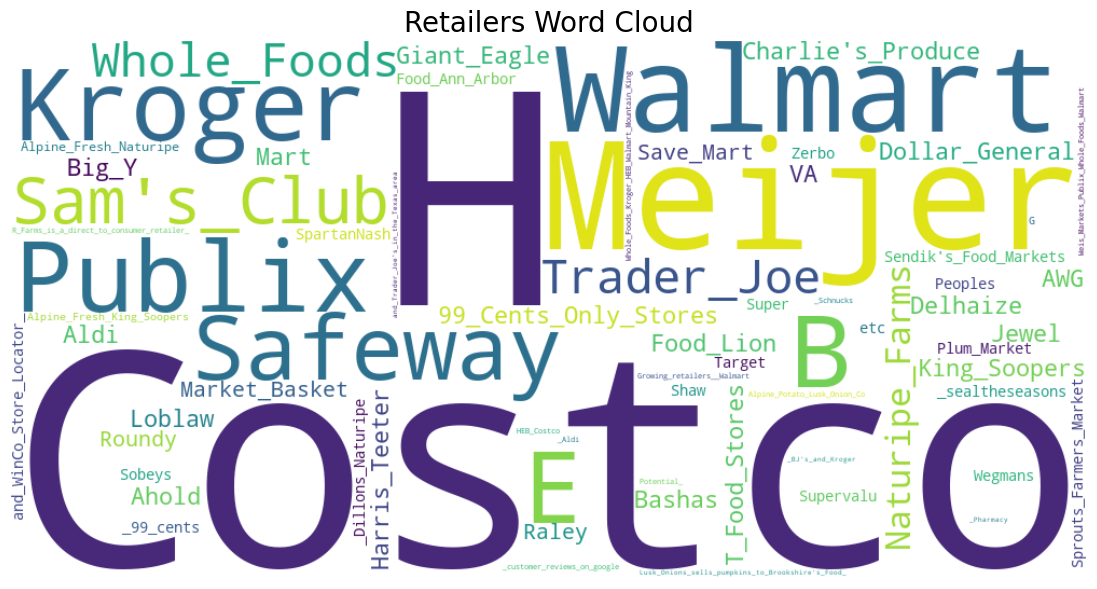

In [42]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import re

df = pd.read_csv("ONION-MASTER.csv")

# Combine all market strings
market_text = " ".join(df["market"].dropna().astype(str).tolist())

# Replace newline and semicolon with commas for clean splitting
market_text = market_text.replace("\n", ",").replace(";", ",").replace("  ", " ")

# Optional: remove content in parentheses
market_text = re.sub(r"\([^)]*\)", "", market_text)

# Split on commas and strip whitespace
retailers = [r.strip() for r in market_text.split(",") if r.strip()]

# Replace spaces with underscores to preserve multi-word retailers
retailers = [r.replace(" ", "_") for r in retailers]

# Join into one string for WordCloud
cleaned_text = " ".join(retailers)

stopwords = {"etc", "Super", "VA", "and", "Potential", "Reviews", "Locator"}
retailers = [r for r in retailers if r.lower() not in stopwords]

# Generate WordCloud
wordcloud = WordCloud(width=1000, height=500, background_color="white", collocations=False).generate(cleaned_text)

# Display
plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Retailers Word Cloud", fontsize=20)
plt.show()

### Bar Chart of Top Retailers

/var/folders/c0/9xhm71h569xfdfjm08qm_pp80000gn/T/ipykernel_73371/2955835960.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




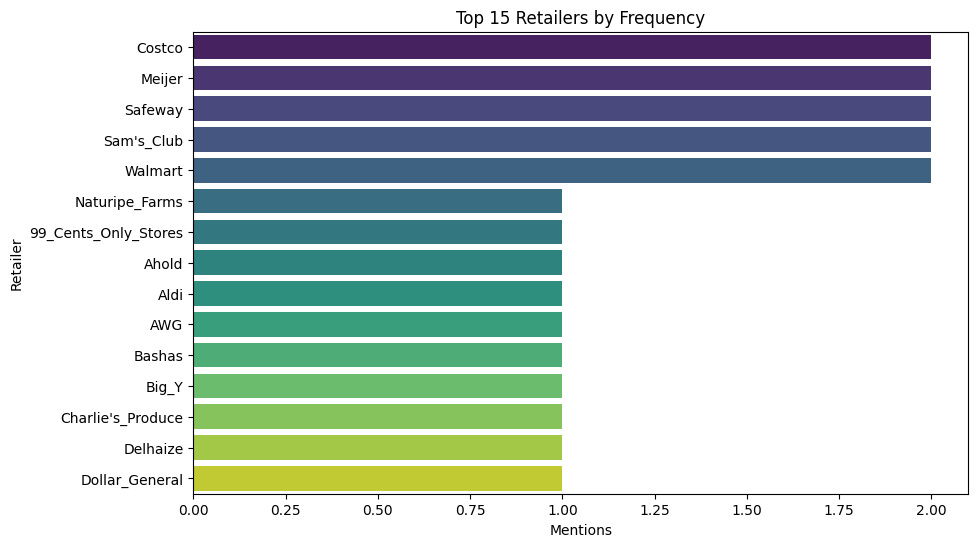

In [34]:
from collections import Counter
import seaborn as sns

top_retailers = Counter(retailers).most_common(15)
df_counts = pd.DataFrame(top_retailers, columns=["Retailer", "Count"])

plt.figure(figsize=(10, 6))
sns.barplot(x="Count", y="Retailer", data=df_counts, palette="viridis")
plt.title("Top 15 Retailers by Frequency")
plt.xlabel("Mentions")
plt.ylabel("Retailer")
plt.show()

### Geospatial Clustering

In [37]:
import pandas as pd
import folium
from sklearn.cluster import KMeans
from folium.plugins import MarkerCluster

df = pd.read_csv("ONION-MASTER.csv")

# Drop missing coordinates
df_geo = df.dropna(subset=["latitude", "longitude"])

# Run KMeans clustering
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df_geo["cluster"] = kmeans.fit_predict(df_geo[["latitude", "longitude"]])

# Create map centered on average location
map_center = [df_geo["latitude"].mean(), df_geo["longitude"].mean()]
cluster_map = folium.Map(location=map_center, zoom_start=6)

# Add colored cluster markers
colors = ["red", "blue", "green", "purple", "orange", "darkred", "lightblue"]
for _, row in df_geo.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=5,
        popup=f"{row['farm']} ({row['case_number']})",
        color=colors[int(row["cluster"]) % len(colors)],
        fill=True,
        fill_opacity=0.7
    ).add_to(cluster_map)

# Save and display
cluster_map.save("geospatial_cluster_map.html")
print("Map saved as 'geospatial_cluster_map.html'")

Map saved as 'geospatial_cluster_map.html'


### Retailer Diversity Bar Chart

/var/folders/c0/9xhm71h569xfdfjm08qm_pp80000gn/T/ipykernel_73371/3875048237.py:28: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




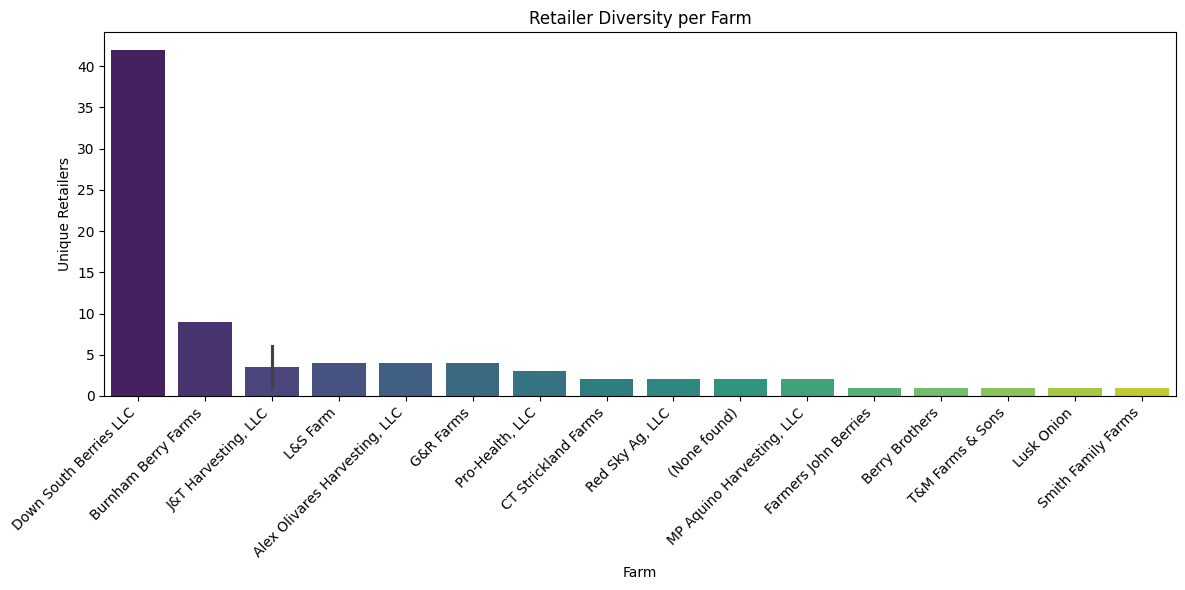

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Load your data
df = pd.read_csv("ONION-MASTER.csv")

# Clean and explode the 'market' column to count retailers
def extract_retailers(market_str):
    if pd.isna(market_str):
        return []
    market_str = re.sub(r"\([^)]*\)", "", market_str)  # remove anything in parentheses
    market_str = market_str.replace("\n", ",").replace(";", ",")
    return [r.strip() for r in market_str.split(",") if r.strip()]

# Apply to DataFrame
df["retailer_list"] = df["market"].apply(extract_retailers)

# Count unique retailers per farm
df["retailer_count"] = df["retailer_list"].apply(lambda x: len(set(x)))

# Sort farms by diversity
df_sorted = df.sort_values("retailer_count", ascending=False)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_sorted, x="farm", y="retailer_count", palette="viridis")
plt.xticks(rotation=45, ha='right')
plt.title("Retailer Diversity per Farm")
plt.ylabel("Unique Retailers")
plt.xlabel("Farm")
plt.tight_layout()
plt.show()